In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [32]:
#see all available columns
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

ejections = pd.read_csv('../data/ejections.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

Text(0, 0.5, 'Height of Pitch')

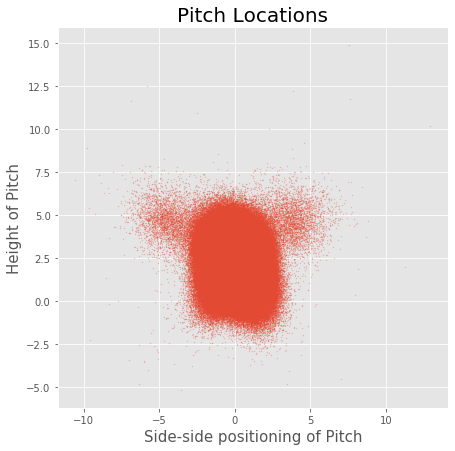

In [23]:
#plots pitch locations
plt.figure(figsize=(7,7))
plt.scatter(pitches['px'].values, pitches['pz'].values, alpha=0.2, s=1)
plt.title('Pitch Locations', size=20)
plt.xlabel('Side-side positioning of Pitch', size=15)
plt.ylabel('Height of Pitch', size=15)

In [26]:
pitches.shape

(2867154, 40)

In [37]:
atbats.shape

(740389, 11)

In [38]:
names.shape

(2218, 3)

In [39]:
ejections.shape

(761, 10)

In [40]:
games.shape

(9718, 17)

In [81]:
#pca need to plot these compositions with every different pitch type and look to see a difference
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(pitches.drop(index=rows_with_nans, axis=0).iloc[:, :8])

array([[ 5.73244358e+02, -1.85875344e+00],
       [ 9.57769975e+02, -6.42601368e-01],
       [ 9.15686865e+02, -4.31602096e-01],
       ...,
       [ 7.81851998e+02, -1.18541668e+00],
       [ 5.86657284e+02, -1.18117267e+00],
       [ 6.22720618e+02, -1.08476803e+00]])

In [80]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]
#new df with dropped nans
pitches.drop(index=rows_with_nans, axis=0)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665000,34.685000,-11.960000,1.720000,3.560000,2.000,-6.409000,-136.065000,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043000,34.225000,-10.085000,1.720000,3.560000,2.000,-8.411000,-135.690000,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368000,35.276000,-11.560000,1.720000,3.560000,2.000,-9.802000,-137.668000,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104000,28.354000,-20.540000,1.740000,3.350000,2.000,-8.071000,-133.005000,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280000,21.774000,-34.111000,1.720000,3.560000,2.000,-6.309000,-110.409000,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867149,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,-5.097492,20.344010,-32.691751,1.535000,3.371000,0.908,-6.895539,-122.140540,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,27.0,8.0,D,X,SL,568,1.0,2.018186e+09,3.0,2.0,2.0,9.0,0.0,0.0,0.0
2867150,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,9.344343,29.592944,-12.127944,1.865118,3.760455,0.892,-12.912992,-141.795182,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,63.0,13.0,B,B,FF,572,1.0,2.018186e+09,0.0,0.0,2.0,1.0,1.0,0.0,0.0
2867151,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,13.292081,30.048939,-11.576431,1.601000,3.490000,0.898,-12.095230,-141.465465,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,30.0,4.0,F,S,FF,577,1.0,2.018186e+09,1.0,0.0,2.0,2.0,0.0,1.0,0.0
2867152,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,12.786338,28.690698,-13.967178,1.601000,3.490000,0.910,-11.422113,-139.199258,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,42.0,13.0,S,S,FF,578,1.0,2.018186e+09,1.0,1.0,2.0,3.0,0.0,1.0,0.0
